# Stochastic processes

In [2]:
#Numpy
import numpy as np
#Scipy
from scipy import special as scsp
from scipy import stats
from numpy import random as rdm
#Pyplot
import matplotlib.pyplot as plt
#Multi-CPU job
from joblib import Parallel, delayed
import multiprocessing as mpg
#Time
import time
#Json
import json
#Os for file management
import os.path

RERUN = False #To rerun all computations (False will load from file if they exist)
extension = '.png' #fig file extension
DIR  = 'D:/pdm_data/'

##### Model parameters from Meyer & Bijeljic 2016

In [3]:
#Bentheimer 500 parameters
Bentheimer500 ={
'name'  : 'Bentheimer 500',
'L0'    :  1.5,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  500,      #Nb of 1D points
'L0/L'  :  11.2,     #Pore length ratio [-]
'phi'   :  0.21,     #Porosity [%]
'kappa' :  1.26,     #Tortuosity [-]
'lmbd/L':  8.33,     #Correlation length [-]
#Theta angle model
'omegat':  5.0,
'taut'  :  0.093,
'sigmat':  0.59,
'mut'   :  41.0,
#Beta angle model
'taub'  :  0.11,
'bb'    :  2.0,
#Log velocity magnitude model
'b'     :  0.56,
'c'     :  1.1,
'alpha' : -4.7,
'mu'    :  1.5,
'sigma' :  2.7
}
#Bentheimer 1000 parameters
Bentheimer1000 ={
'name'  :  'Bentheimer 1000',
'L0'    :  3.0,      #Sample length [mm]
'Deltax':  3.0,      #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  22.6,     #Pore length ratio [-]
'phi'   :  0.22,     #Porosity [%]
'kappa' :  1.65,     #Tortuosity
'lmbd/L':  8.32,     #Correlation length [-]
#Theta angle model
'omegat':  4.3,
'taut'  :  0.12,
'sigmat':  0.69,
'mut'   :  38.0,
#Beta angle model
'taub'  :  0.13,
'bb'    :  1.9,
#Log velocity magnitude model
'b'     :  0.57,
'c'     :  1.3,
'alpha' : -3.6,
'mu'    :  1.5,
'sigma' :  2.5
}
#Estaillades parameters
Estaillades = {
'name'  :  'Estaillades',
'L0'    :  3.31,     #Sample length [mm]
'Deltax':  3.31,     #Resolution [um]
'n'     :  1000,     #Nb of 1D points
'L0/L'  :  11.7,     #Pore length ratio [-]
'phi'   :  0.11,     #Porosity [%]
'kappa' :  2.26,     #Tortuosity
'lmbd/L':  36.2,     #Correlation length [-]
#Theta angle model
'omegat':  10.0,
'taut'  :  0.018,
'sigmat':  0.84,
'mut'   :  17.0,
#Beta angle model
'taub'  :  0.014,
'bb'    :  7.0,
#Log velocity magnitude model
'b'     :  0.63,
'c'     :  3.0,
'alpha' : -5.1,
'mu'    :  2.2,
'sigma' :  5.1
}

## 1) Log velocity model from Meyer and Bijeljic 2016

#### 1.1) PDF, drift and diffusion functions 
$$ p(v)=\frac{1}{\sqrt{2\pi}\sigma}\exp\left[-\frac{(v-\mu)^2}{2\sigma^2}\right](1-\textrm{erf}\left[-\frac{\alpha(v-\mu)}{\sqrt{2}\sigma}\right])$$

$$a(v)=\frac{d(v)}{2}\ln[p(v)d(v)]$$

$$d(v)=c\exp[bv]$$

In [4]:
#Skew-normal PDF
def p_skew(v,sample) :
    alpha = sample['alpha']
    mu    = sample['mu']
    sigma = sample['sigma']
    p = 1/np.sqrt(2.0*np.pi*sigma**2)*np.exp(-(v-mu)**2/(2.0*sigma**2))*scsp.erfc(-alpha*(v-mu)/np.sqrt(2.0*sigma**2))
    return p


#Diffusion function from DWM
def d(v,sample) :
    b = sample['b']
    c = sample['c']
    return c*np.exp(b*v)

#Drift function from DWM
def a(v,sample) :
    eps  = 0.1
    p_p1 = p_skew(v+eps,sample); p_m1 = p_skew(v-eps,sample);
    d_p1 = d(v+eps,sample);      d_m1 = d(v-eps,sample);
    d_   = d(v,sample);
    grad = (np.log(p_p1 * d_p1)-np.log(p_m1 * d_m1))/(2.0*eps)
    return d_/2.0 * grad

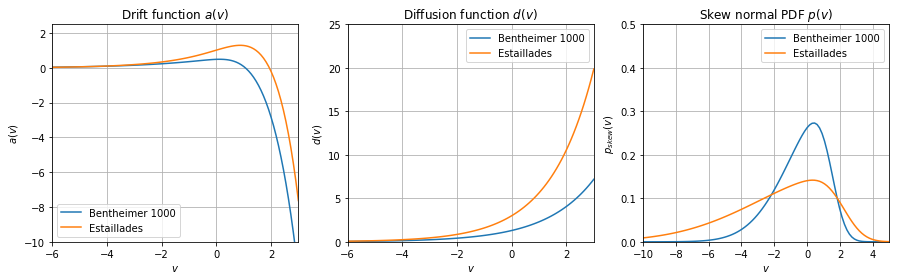

In [5]:
samples = [Bentheimer1000, Estaillades]
nv=100
(v_min, v_max) = (-6.0, 3.0)
v=np.linspace(v_min,v_max,nv)
dv= (v_max-v_min)/nv
fig, axs = plt.subplots(1,3, figsize= (15,4))

for (i,sample) in zip(range(len(samples)),samples) :
    axs[0].plot(v,a(v,sample),label = sample['name'])
    axs[1].plot(v,d(v,sample),label = sample['name'])
    axs[2].plot(np.linspace(-10,5,nv),p_skew(np.linspace(-10,5,nv),sample),label = sample['name'])

axs[0].set_title(r'Drift function $a(v)$')
axs[0].set_xlabel(r'$v$')
axs[0].set_ylabel(r'$a(v)$')
axs[0].set_xlim((-6,3))
axs[0].set_ylim((-10,2.5))
axs[0].legend()
axs[0].grid(True)

axs[1].set_title(r'Diffusion function $d(v)$')
axs[1].set_xlabel('$v$')
axs[1].set_ylabel(r'$d(v)$')
axs[1].set_xlim((-6,3))
axs[1].set_ylim((0,25))
axs[1].legend()
axs[1].grid(True)

axs[2].set_title(r'Skew normal PDF $p(v)$')
axs[2].set_xlabel('$v$')
axs[2].set_ylabel(r'$p_{skew}(v)$')
axs[2].set_xlim((-10,5))
axs[2].set_ylim((0,0.5))
axs[2].legend()
axs[2].grid(True)

plt.savefig(DIR+'Figures/MP_functions'+extension)

#### Log velocity markov process

In [6]:
#Log velocity magnitude model from Meyer and Bijeljic 2016
def LVM_process(sample, param):
    if param['seed'] is not None : 
        rdm.seed(param['seed'])
    else :
        rdm.seed()
    Tmax = param['Tmax']; dt  = param['dt']; 
    v0   = param['v0'];   csf = param['csf']; 
    Nt        = int(Tmax/dt)+1
    delta     = dt #Wiener process 
    track     = range(int(Nt/csf)) #If we do not want to track the whole evolution
    v_track   = np.zeros(int(Nt/csf)) #Resulting time serie
    v_        = v0
    for i in range(Nt) :
        if (i in track):
            v_track[i] = v_
        dv = a(v_,sample)*dt + np.sqrt(d(v_,sample))*rdm.normal(loc=0.0, scale=np.sqrt(dt), size=None)
        v_ = v_ + dv
    return v_track

def Save_data(MP_dict, filename) :
    #Copy data into non np array dict for json formating
    No_np = {}
    for key in MP_dict : No_np[key] = [v for v in MP_dict[key]]
    with open(filename, 'w') as outfile:  
        json.dump(No_np, outfile)
    
def Load_data(filename) :
    MP_dict = {}
    with open(filename, 'r') as outfile:  
        MP_dict = json.load(outfile)
    #Converting arrays in np array
    for key in MP_dict : MP_dict[key] = np.array(MP_dict[key])
    return MP_dict

## Running processes

In [7]:
samples = [Bentheimer1000, Estaillades]
Nmp = 1
MP_params = {
'seed': 12345,
'v0'  : 1.5,
'dt'  : 0.01,
'Tmax': 100.0,
'csf' : 1.0
}
MP_example  = {'params' : MP_params}

for sample in samples :
    MP_example[sample['name']]  = Parallel(n_jobs=-2)(
        delayed(LVM_process)
        (sample, MP_params) for i in range(Nmp))

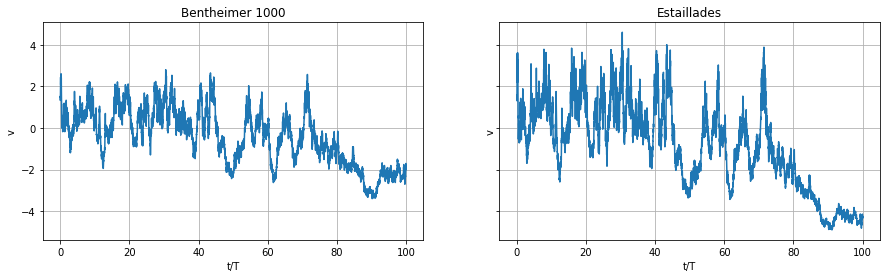

In [8]:
fig, axs = plt.subplots(1,2, sharey = True, figsize=(15,4))
for (i,sample) in zip(range(len(samples)),samples) :
    for n in range(Nmp) :
        Tmax = MP_example['params']['Tmax']
        Nt   = len(MP_example[sample['name']][n])
        timerange = np.linspace(0,Tmax,Nt)
        axs[i].plot(timerange,MP_example[sample['name']][n],'-')
        axs[i].grid(True);
        axs[i].set_ylabel('v');
        axs[i].set_xlabel('t/T');
        axs[i].set_title(sample['name']);
plt.savefig(DIR+'Figures/MP_examples'+extension)

### Process Statistics and PDF comparison

In [9]:
samples = [Bentheimer1000, Estaillades]
Nmp = 100
MP_params = {
'seed': None,
'v0'  : 1.5,
'dt'  : 0.005,
'Tmax': 300.0,
'csf' : 1.0
}
MP_lvm  = {'params' : MP_params}
fname   = DIR+'Markov_processes/MP_lvm.dat'
rerun   = False
if (not os.path.isfile(fname)) or rerun:
    for sample in samples :
        MP_lvm[sample['name']]  = Parallel(n_jobs=-2)(
            delayed(LVM_process)
            (sample, MP_params) for i in range(Nmp))
        MP_lvm[sample['name']]=np.reshape(MP_lvm[sample['name']],len(MP_lvm[sample['name']][0])*Nmp)
        Save_data(MP_lvm,fname)
else :
    print('Load data...')
    MP_lvm = Load_data(fname)
    print('Done')

Load data...
Done


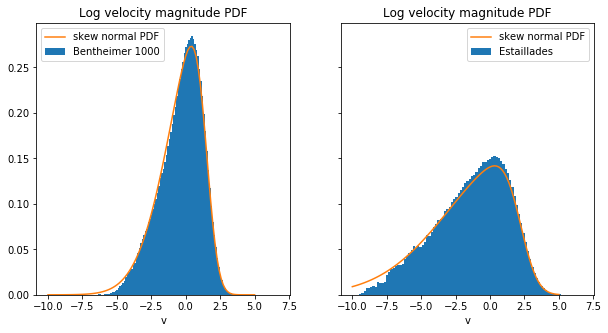

In [10]:
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True, sharex=True)
NBINS = 100
for (i,sample) in zip(range(len(samples)),samples) :
    axs[i].hist(MP_lvm[sample['name']], bins = NBINS, density = True, log = False, label = sample['name'])
    v = np.linspace(-10,5,100)
    axs[i].plot(v,p_skew(v,sample), label = 'skew normal PDF');
    axs[i].set_title('Log velocity magnitude PDF')
    axs[i].set_xlabel('v')
    axs[i].legend()
plt.savefig(DIR+'Figures/MP_pdf'+extension)